NeurEx Project 1: Binary Classification of Visual Stimuli

EEG Data Preprocessing Pipeline Demo

Step 1: Imports

In [ ]:
# This is a simple command to install the necessary toolboxes into our environment
# !pip install mne autoreject numpy scikit-learn imbalanced-learn matplotlib
# We will use a lot of "toolboxes" for our analysis
# Think of a toolbox as a library of "tool", or functions that are premade and avaliable for us to use
# This allows us to use specialized functions that optimally preprocess the data without the need for us to write our own functions
# We still need to understand the functions we use, how they change the data, what the datatype they output are, and how we can work with them
# Thankfully there is documentation (instructions) avaliable online that can tell us everything we need to know
# Finally: USE CHATGPT!!!!!! We cannot emphasize enough how helpful chatgpt is for explaining concepts, debugging code, and helping you create optimized pipelines
import os
import mne
from mne.preprocessing import ICA
from autoreject import AutoReject
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

Step 2: Load in the Data

In [ ]:
'''
# Define the root directory where the data is stored
# This is the path to the directory that has your data
bids_root = "/Users/BAEK/Code/neurEx/project"

# This will iterate through each file in the folder that starts with sub, and then adds each subject to a list
# Hint: os has a function called os.listdir that takes a folder path and returns a list with all of the directory contents
subjects = [sub for sub in os.listdir("/Users/BAEK/Code/neurEx/project/N170 Raw Data BIDS-Compatible") if sub.startswith("sub")]
# Create a variable that holds the current task
# Hint: Our task is N170
task = "task-N170"

# Create a variable subject that will contain the first subject in the list subjects
# This is the subject we will preprocess the data for
# Hint: Remember indexing?
subject = subjects[0]
print(f'Processing subject: {subject}')

# Define the path to the EEG data in EEGLAB format (.set file)
# You will want to use os.path.join to join the bids_root, subject and filename
# This creates the path that we will use to load in the data
eeg_path = os.path.join(bids_root, subject, 'eeg', f'{subject}_{task}_eeg.set')

# Read the raw EEG data using MNE's EEGLAB reader
# Hint: MNE has a function called mne.io.read_raw_eeglab
# You pass the path to the data and set the preload parameter to be true
raw = mne.io.read_raw_eeglab(eeg_path, preload=True)
''' 
# Define the root directory where the data is stored
# This is the path to the directory that has your data
bids_root = "/Users/BAEK/Code/neurEx/project/tempData"
# This will iterate through each file in the folder that starts with sub, and then adds each subject to a list
# Hint: os has a function called os.listdir that takes a folder path and returns a list with all of the directory contents
subjects = [sub for sub in os.listdir(bids_root) if sub.startswith('sub')]
# Create a variable that holds the current task
# Hint: Our task is N170
task = 'task-N170'
# Create a variable subject that will contain the first subject in the list subjects
# This is the subject we will preprocess the data for
# Hint: Remember indexing?
subject = subjects[0]
print(f'Processing subject: {subject}')
# Define the path to the EEG data in EEGLAB format (.set file)
# You will want to use os.path.join to join the bids_root, subject and filename
# This creates the path that we will use to load in the data
eeg_path = os.path.join(bids_root, subject, 'eeg', f'{subject}_{task}_eeg.set')
# Read the raw EEG data using MNE's EEGLAB reader
# Hint: MNE has a function called mne.io.read_raw_eeglab
# You pass the path to the data and set the preload parameter to be true
raw = mne.io.read_raw_eeglab(eeg_path, preload=True)

Processing subject: sub-002
Reading /Users/BAEK/Code/neurEx/project/data/sub-002/eeg/sub-002_task-N170_eeg.fdt
Reading 0 ... 683007  =      0.000 ...   666.999 secs...


Step 3: Create a new event mapping for epoching

In [4]:
# Create a dictionary of all integer event codes
# Very simple, eg. 1:1, 43:43, 187:187
# Allows us to use the "events_from_annotations" MNE function to create our events array
annotations_mapping = {desc: int(desc) for desc in set(raw.annotations.description)}
print("Annotations mapping:", annotations_mapping)

# Extract events using the annotations mapping
# Events = an n events x 3 array
# Column 1 = the sample numbers that represent the beginning of the epoch
# Column 2 = all 0s
# Column 3 = the event type (face, car, etc)
events, _ = mne.events_from_annotations(raw, event_id=annotations_mapping)

# Create a mapping from original event codes to condition labels
# Each number from 1-202 has an associated event
# Ex: 2 = face, 45 = car
event_code_to_condition = {}

# Map "1-40" to "Stimulus - faces"
for code in range(1, 41):
    event_code_to_condition[code] = 'Stimulus/Face'
# Map "41-80" to "Stimulus - cars"
for code in range(41, 81):
    event_code_to_condition[code] = 'Stimulus/Car'
# Map "101-140" to "Stimulus - scrambled faces"
for code in range(101, 141):
    event_code_to_condition[code] = 'Stimulus/ScrambledFace'
# Map "141-180" to "Stimulus - scrambled cars"
for code in range(141, 181):
    event_code_to_condition[code] = 'Stimulus/ScrambledCar'

# Map "201" to "Response - correct"
event_code_to_condition[201] = 'Response/Correct'
# Map "202" to "Response - error"
event_code_to_condition[202] = 'Response/Error'

# Assign new integer event IDs to each condition label
condition_label_to_event_id = {
    'Stimulus/Face': 1,
    'Stimulus/Car': 2,
    'Stimulus/ScrambledFace': 3,
    'Stimulus/ScrambledCar': 4,
    'Response/Correct': 5,
    'Response/Error': 6
}

# Create a mapping from original event codes to new integer event IDs
original_to_new_event_id = {}

# Iterates through each event code (1-202)
for code in event_code_to_condition:
    # Extracts the condition label associated with the event code
    condition_label = event_code_to_condition[code]
    # Finds the new event code (1-6) that corresponds to the condition label
    new_event_id = condition_label_to_event_id[condition_label]
    # Creates new event code array where each event code (1-202) is mapped to its new event code (1-6)
    original_to_new_event_id[code] = new_event_id

# Apply the event ID mapping to the events array
# Based on the original event codes (1-202), new event codes (1-6) are assigned to each event
events[:, 2] = np.array([original_to_new_event_id.get(code, -1) for code in events[:, 2]])

# Remove events with code -1 (events not in our mapping)
events = events[events[:, 2] != -1]

# Define the event_id mapping for epoching
event_id = condition_label_to_event_id

Annotations mapping: {'147': 147, '13': 13, '101': 101, '16': 16, '19': 19, '170': 170, '151': 151, '131': 131, '35': 35, '140': 140, '175': 175, '138': 138, '136': 136, '9': 9, '70': 70, '128': 128, '174': 174, '105': 105, '29': 29, '14': 14, '62': 62, '157': 157, '111': 111, '55': 55, '11': 11, '162': 162, '79': 79, '114': 114, '8': 8, '38': 38, '178': 178, '180': 180, '66': 66, '166': 166, '5': 5, '71': 71, '127': 127, '46': 46, '102': 102, '60': 60, '4': 4, '33': 33, '146': 146, '172': 172, '25': 25, '139': 139, '47': 47, '20': 20, '56': 56, '148': 148, '1': 1, '37': 37, '75': 75, '154': 154, '30': 30, '165': 165, '32': 32, '134': 134, '124': 124, '115': 115, '171': 171, '41': 41, '15': 15, '158': 158, '34': 34, '130': 130, '149': 149, '72': 72, '49': 49, '68': 68, '52': 52, '153': 153, '63': 63, '23': 23, '65': 65, '44': 44, '176': 176, '45': 45, '152': 152, '76': 76, '179': 179, '110': 110, '168': 168, '78': 78, '17': 17, '150': 150, '122': 122, '144': 144, '39': 39, '40': 40, '1

Step 4: Create the montage (EEG channels used) and add it to the epoch object

In [5]:
# Set channel types for EOG channels
# EOG channels are different from EEG channels
# EEG channels measures electrical activity in the brain
# EOG channels measure electrical activity produced from your eye (not very important)
# We need to distinguish them from the EEG channels
eog_channels = ['HEOG_left', 'HEOG_right', 'VEOG_lower']
for ch in eog_channels:
    if ch in raw.ch_names:
        raw.set_channel_types({ch: 'eog'})

# Apply montage directly, ignoring missing channels
# This creates a digMontage object
# A digMontage object contains each electrode and the positional data associated from the scalp
# Hint: use mne.channels.make_standard_montage, the montage we are using is the standard 1020
montage = mne.channels.make_standard_montage('standard_1020')

# This sets the montage in the rawEEGLAB object
# Hint: use the set_montage function
raw.set_montage(montage, match_case=False)

<RawEEGLAB | sub-002_task-N170_eeg.fdt, 33 x 683008 (667.0 s), ~172.0 MB, data loaded>

Not setting metadata
642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 642 events and 820 original time points ...
0 bad epochs dropped


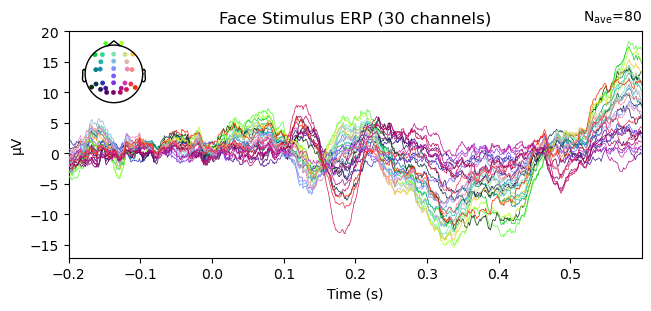

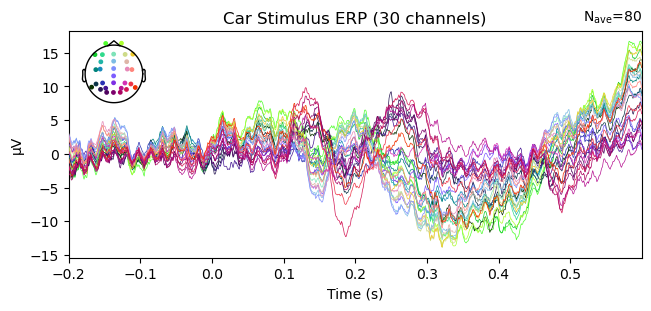

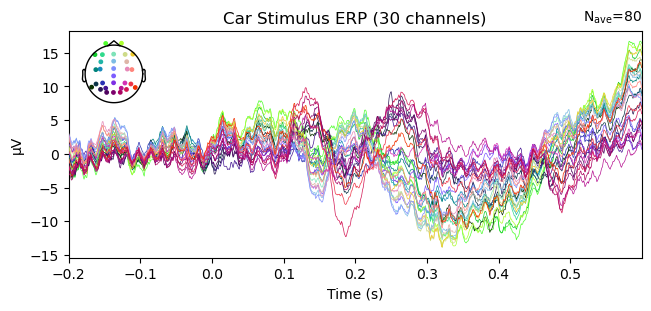

In [6]:
# IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True, detrend=1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

Step 5: Start Preprocessing!

Step 5a: Filter!

In [7]:
# Bandpass filter the data between 0.1Hz and 30Hz using a "firwin" filter
# Hint: mne.filter()
raw.filter(0.1, 30., fir_design='firwin')

# Apply notch filter at 60 Hz using a "firwin" filter
# Hint: mne.notch_filter()
raw.notch_filter(60., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


<RawEEGLAB | sub-002_task-N170_eeg.fdt, 33 x 683008 (667.0 s), ~172.0 MB, data loaded>

Not setting metadata
642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 642 events and 820 original time points ...
0 bad epochs dropped


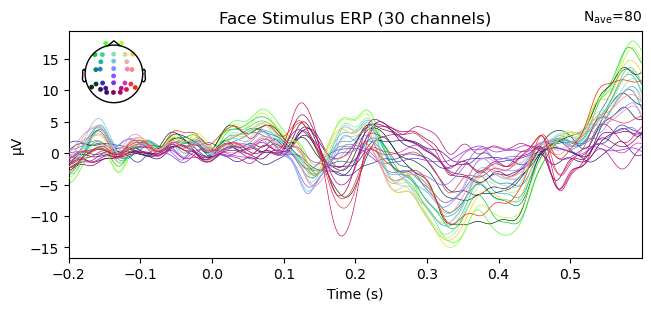

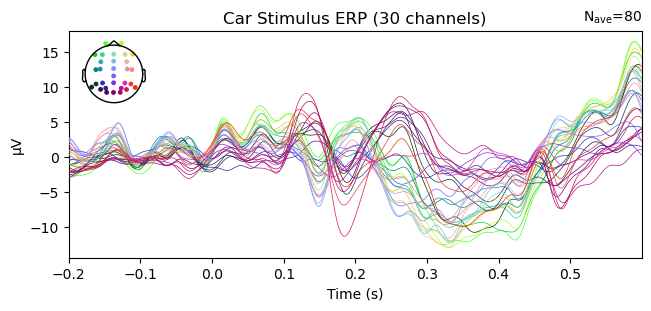

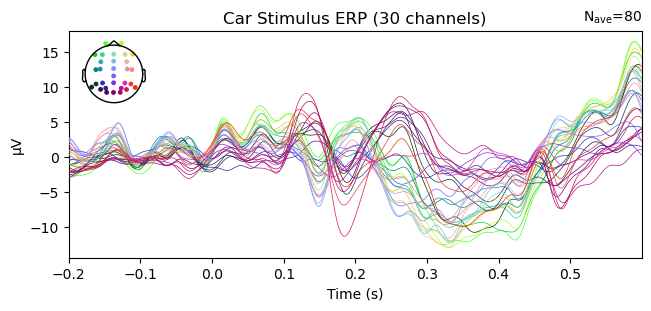

In [8]:
# IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True, detrend=1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

Step 5b: Re-Reference!

In [9]:
# Re-reference to the average of all channels
# Hint: mne.set_eeg_reference()
raw.set_eeg_reference(ref_channels='average')


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-002_task-N170_eeg.fdt, 33 x 683008 (667.0 s), ~172.0 MB, data loaded>

Not setting metadata
642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 642 events and 820 original time points ...
0 bad epochs dropped


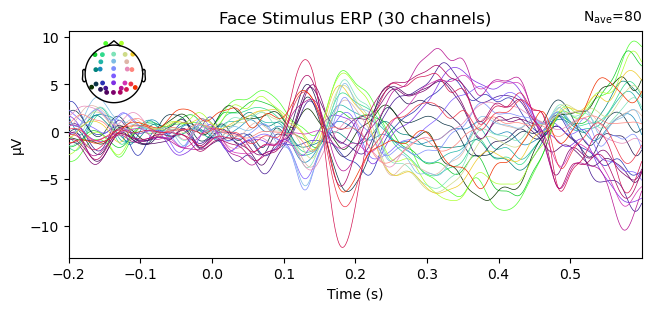

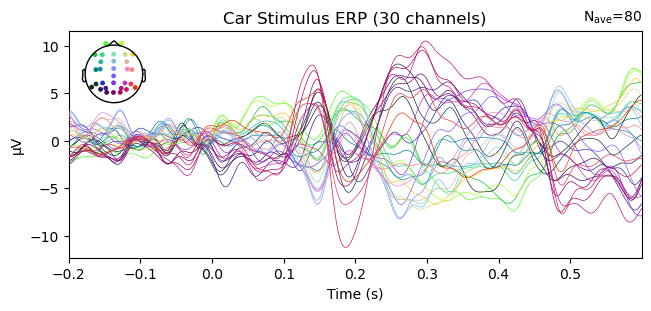

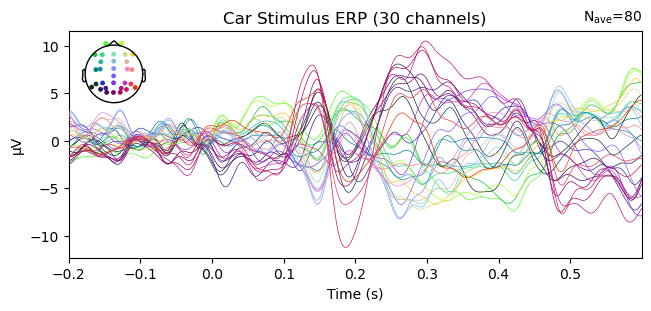

In [10]:
# IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True, detrend=1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

Step 5c: Apply ICA!

In [12]:
# Apply ICA to remove EOG (eye movement) artifacts
# Eye movements such as blinks create distortions in our data called "artifacts"
# These distortions can mask physiological data we are trying to extract
# Lets remove them!
# Hint: Use the ICA module from mne.preprocessing
# number of components = 15
# method = 'fastica'
# random_state = 97
# max_iter = 'auto'
ica = ICA(n_components = 15, method = 'fastica', random_state = 97, max_iter = 'auto')
# Apply the ica to the raw data
# Hint: use ICA's fit method
ica.fit(raw)

# Find ICA components correlated with EOG artifacts
# This identifies data points that are most likely associated with EOG artifacts and adds them to our ICA object
# Hint: Use ica.find_bads_eog and the eog_channels object that we created earlier
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name = eog_channels)
# Exclude the found EOG artifacts
ica.exclude = eog_indices

# Apply the ICA solution to raw data to exclude the artifacts
# Hint: Use ica.apply
raw_corrected = ica.apply(raw.copy())

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 128.0s.
Using EOG channels: HEOG_left, HEOG_right, VEOG_lower


/opt/miniconda3/envs/neur/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 s

Not setting metadata
642 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 642 events and 820 original time points ...
0 bad epochs dropped


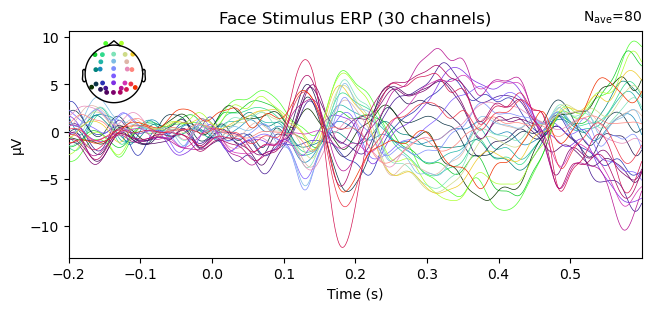

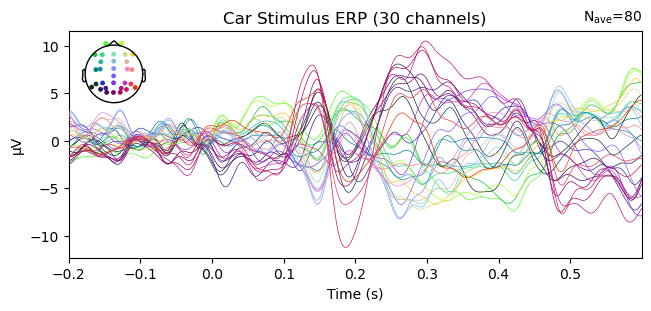

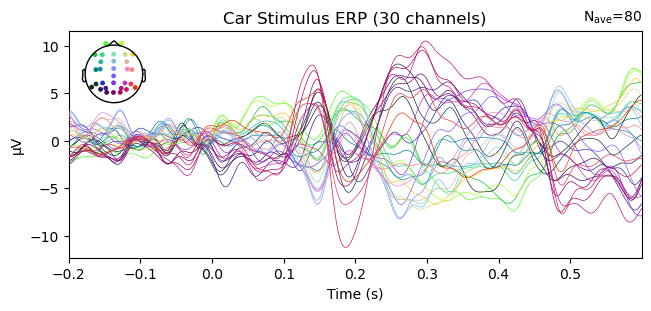

In [13]:
# IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True, detrend=1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

Step 6: Define timerange for each epoch

In [14]:
# Define the time window (around the stimulus at t = 0) for each epoch
# Hint: Our time window for each epoch is -200ms to 600ms
tmin, tmax = -0.2, 0.6

# We wont end up using the baseline correction just yet, but its function is to center all of the responses around 0 so they have the same starting point
# This allows us to make better comparisons
# Just define the interval for now, it is from -200 ms to 0 ms
baseline = (tmin, 0)

Step 7: Create the MNE epochs object!

In [15]:
# Create an MNE epochs object!
# This object contains the preprocessed EEG data seperated into each epoch
# .average() can be called on this object to average each epoch and obtain the evoked response
# This can be achieved with the mne.Epochs method
# You have created most of the parameters (use the API to determine what to enter)
# Parameters that we have not created (include these last):
# baseline=None, preload=True, detrend=1
epochs = mne.Epochs(
    raw=raw_corrected,       # Use the corrected raw data after ICA
    events=events,           # The events array created from annotations
    event_id=event_id,       # The dictionary mapping events to labels
    tmin=tmin,               # Start of the time window (-0.2 seconds)
    tmax=tmax,               # End of the time window (0.6 seconds)
    baseline=baseline,       # Baseline interval from -0.2 to 0 seconds
    preload=True,            # Preload data for faster access
    detrend=1                # Linear detrending to remove DC offset
)

# Congradulations, you have successfully preprocessed and epoched EEG data for data analysis or deep learning purposes!

Not setting metadata
642 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 642 events and 820 original time points ...
0 bad epochs dropped


Haha you thought we were done

Step 8: Reject bad epochs (due to movement artifacts).

Movement artifacts are like EOG artifacts, except they are caused by bodily movement, such as shaking your head, or moving aronud in your seat during recording. Epochs with movement corrupted data need to be removed so that they do not hinder analysis.

In [16]:
# Thankfully there is a toolbox that can be used to auto reject bad epochs with 2 lines of code :)
# Apply Autoreject to automatically reject bad epochs
# Create the AutoReject object: AutoReject()
ar = AutoReject()

# Apply the auto rejection to the epochs object we created
# This can be achieved with SKLearns fit_transform function
# Make sure return_log=True
epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

Dropped 75 epochs: 5, 7, 9, 29, 31, 35, 39, 47, 63, 72, 109, 113, 115, 127, 167, 193, 200, 203, 231, 233, 234, 251, 253, 255, 269, 270, 295, 296, 305, 326, 329, 331, 333, 357, 358, 359, 361, 362, 377, 387, 390, 391, 393, 397, 405, 409, 415, 453, 454, 457, 458, 461, 467, 469, 477, 493, 497, 499, 503, 506, 507, 508, 525, 546, 550, 551, 557, 565, 587, 601, 610, 611, 625, 631, 641


Step 9: Finally we will apply the baseline correction

In [19]:
# Apply baseline correction after artifact rejection
# Hint: use the mne.apply_baseline function with the baseline we created earlier
epochs_clean.apply_baseline(baseline=baseline)

Applying baseline correction (mode: mean)


<Epochs | 567 events (all good), -0.2 – 0.6 s (baseline -0.2 – 0 s), ~117.1 MB, data loaded,
 'Stimulus/Face': 75
 'Stimulus/Car': 78
 'Stimulus/ScrambledFace': 75
 'Stimulus/ScrambledCar': 76
 'Response/Correct': 255
 'Response/Error': 8>

Step 10: Lets visualize the preprocessed data!

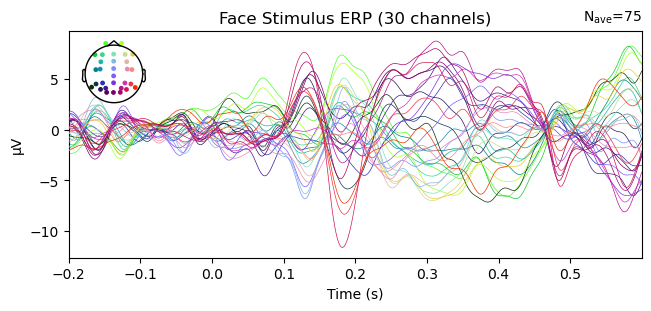

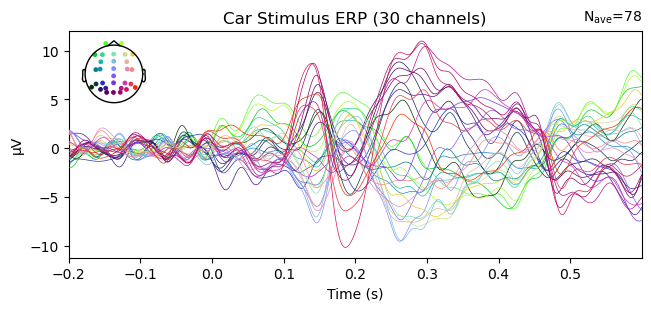

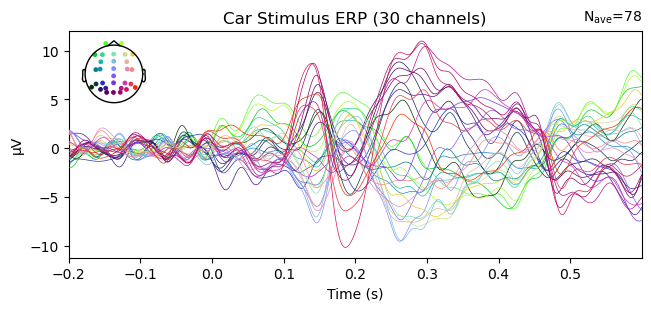

In [24]:
# Simply compute the average (evoked) response for each condition
# Hint use the .average() function on the face and car stimulus data from epochs_clean
evoked_face = epochs_clean['Stimulus/Face'].average()
evoked_Car = epochs_clean['Stimulus/Car'].average()

# Plotting the ERP for Face
# Use mne's plot function with the parameters:
# titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)
# plt.savefig('average_erp_face.png') # Optional: Save the plot!

# Plotting the ERP for Object
# Use mne's plot function with the parameters:
# titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)
# plt.savefig('average_erp_car.png') # Optional: Save the plot!


Now you actually are done, in reality we would run this preprocessing script in batch style and append all of the data for each class into one data structure that we would further process to optimize it for deep learning classification.

Tune in next week to delve into how we can analyze this data with deep learning!